# 부도예측 확률모형

In [1]:
#필요한 모듈 불러오기
from pandas import DataFrame, Series
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import os
import seaborn as sb
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [2]:
#클리닝된 데이터 불러오기 
data=pd.read_csv(\Lending_Club_Data_Subsample.csv',engine='python')

In [3]:
df=DataFrame(data)

In [4]:
# data를 training set과 test set으로 나누기
train, test = np.split(df.sample(frac=1), [int(.8*len(df))])  #끊는 지점 표시 (80% 지점에서 끊어줌)
# train, validation, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))]) # 6:2:2 로 나눔

In [5]:
#만들어진 training, test data 구조 살펴보기.
train.shape

(800, 26)

In [6]:
test.shape

(200, 26)

In [7]:
# training set과 test set에서의 종속변수 분포 비교하기
train.bad.describe()

count    800.000000
mean       0.128750
std        0.335133
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: bad, dtype: float64

In [8]:
test.bad.describe()

count    200.000000
mean       0.145000
std        0.352984
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: bad, dtype: float64

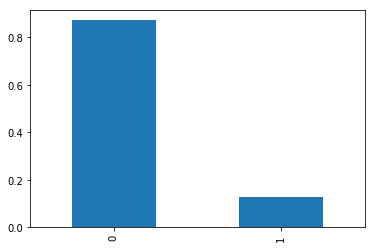

In [9]:
#히스토그램으로 두 데이터 셋의 bad 비율 비교하기
(train.bad.value_counts()/len(train)).plot(kind='bar')

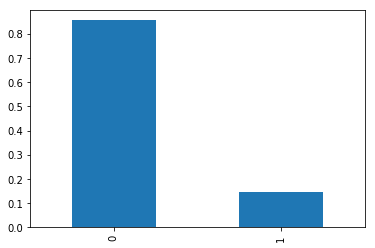

In [10]:
(test.bad.value_counts()/len(test)).plot(kind='bar')

# Linear Probability Model (선형 확률 모형)

In [11]:
#training set의 종속변수와 설명변수를 각각 y_train과 X_train으로 지정
y_train = train['bad']
X_train = train.drop('bad',axis=1)

In [12]:
# Linear probability Model
# 클리닝 된 데이터에 모든 카테고리가 다 포함되어 있어 perfect multicollinearity를 막기 위해 
# intercept가 없는 모형을 추정함. 
# 간단한 설명 참고: http://www.algosome.com/articles/dummy-variable-trap-regression.html
lpm = LinearRegression(fit_intercept=False) 
lpm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [13]:
#각 변수별 계수 확인하기
print(lpm.intercept_)
print(lpm.coef_)

0.0
[  2.33270399e-02   8.51503537e-03  -1.74733603e-02   2.94585465e-13
   8.00674196e-02   3.38705077e-03   9.10490875e-02   1.23301902e-02
   2.29467244e-02   5.91592237e-02   6.78662911e-02   2.65698471e-02
  -1.64917618e-06   7.03713045e-05  -4.78490038e-07   1.75934042e-03
   5.04640573e-04   1.73391972e-02   3.94980113e-03  -2.48425040e-02
  -1.53019533e-03   9.61846886e-02  -2.25438444e-03   5.91578592e-11
  -2.51110897e-03]


In [14]:
coeff = DataFrame(lpm.coef_, index=X_train.columns, columns=["coefficient"])
coeff.head()

,coefficient
purpose_1,2.332704e-02
purpose_2,8.515035e-03
purpose_3,-1.747336e-02
purpose_4,2.945855e-13
purpose_5,8.006742e-02


In [15]:
#계수를 이용한 predicted probability 계산하기
train['lpm_pred_prob'] = lpm.predict(X_train)

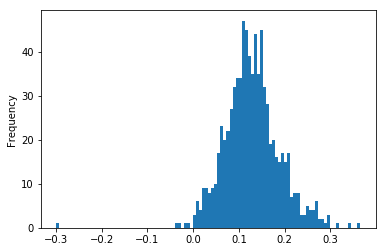

In [16]:
#training set의 predicted Probability의 분포 확인하기
train.lpm_pred_prob.plot(kind='hist', bins=100) #histogram
#train.lpm_pred_prob.plot(kind='kde') #kernel density function

In [17]:
#test set의 종속변수와 설명변수 지정하기
y_test = test['bad']
X_test = test.drop('bad',axis=1)

In [19]:
#training set에서 계산한 coefficient를 이용하여 test set의 부도 확률을 predict 하기
result = lpm.predict(X_test)
result = DataFrame(result)
result.columns = ['lpm_pred_prob']

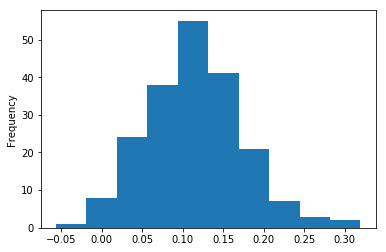

In [22]:
#test set의 predicted Probability의 분포 확인하기
result.lpm_pred_prob.plot(kind='hist', bins=10) #histogram
#result.lpm_pred_prob.plot(kind='kde') #kernel density function

## AUROC 로 모형 평가하기

In [23]:
#roc_curve를 이용하여 FPR, TPR, Threshold 설정하기 
fpr,tpr,thresholds=roc_curve(test.bad, result.lpm_pred_prob)

In [24]:
#False Positive rate(1-specificity=FP/(TN+FP))
fpr

array([ 0.        ,  0.00584795,  0.00584795,  0.01169591,  0.01169591,
        0.06432749,  0.06432749,  0.07017544,  0.07017544,  0.08187135,
        0.08187135,  0.12280702,  0.12280702,  0.14035088,  0.14035088,
        0.21637427,  0.21637427,  0.23976608,  0.23976608,  0.28070175,
        0.28070175,  0.30994152,  0.30994152,  0.33918129,  0.33918129,
        0.39181287,  0.39181287,  0.40935673,  0.40935673,  0.43859649,
        0.43859649,  0.45614035,  0.45614035,  0.48538012,  0.48538012,
        0.52046784,  0.52046784,  0.5380117 ,  0.5380117 ,  0.5497076 ,
        0.5497076 ,  0.67836257,  0.67836257,  0.68421053,  0.68421053,
        0.69590643,  0.69590643,  0.80701754,  0.80701754,  0.9005848 ,
        0.9005848 ,  0.97076023,  0.97076023,  1.        ])

In [25]:
#True Positive rate(sensitivity=TP/(TP+FN))
tpr

array([ 0.        ,  0.        ,  0.03448276,  0.03448276,  0.06896552,
        0.06896552,  0.10344828,  0.10344828,  0.13793103,  0.13793103,
        0.17241379,  0.17241379,  0.20689655,  0.20689655,  0.24137931,
        0.24137931,  0.27586207,  0.27586207,  0.31034483,  0.31034483,
        0.4137931 ,  0.4137931 ,  0.44827586,  0.44827586,  0.51724138,
        0.51724138,  0.55172414,  0.55172414,  0.5862069 ,  0.5862069 ,
        0.62068966,  0.62068966,  0.65517241,  0.65517241,  0.68965517,
        0.68965517,  0.72413793,  0.72413793,  0.75862069,  0.75862069,
        0.79310345,  0.79310345,  0.82758621,  0.82758621,  0.86206897,
        0.86206897,  0.89655172,  0.89655172,  0.93103448,  0.93103448,
        0.96551724,  0.96551724,  1.        ,  1.        ])

In [26]:
#Thresholds(cut-off points)
thresholds

array([ 1.31915784,  0.31915784,  0.29359336,  0.27789834,  0.25931553,
        0.2062125 ,  0.2058745 ,  0.20379039,  0.20335367,  0.20167232,
        0.19733906,  0.18068641,  0.17882165,  0.17481021,  0.17370487,
        0.15823904,  0.15720355,  0.15215633,  0.15205355,  0.14502026,
        0.14338399,  0.13779213,  0.1376964 ,  0.13559685,  0.13385649,
        0.12736032,  0.12708865,  0.125963  ,  0.12571838,  0.12194979,
        0.12172606,  0.11856338,  0.11809595,  0.11473123,  0.11347082,
        0.10899143,  0.1084582 ,  0.10598353,  0.10588226,  0.10234523,
        0.10123064,  0.08451946,  0.084438  ,  0.08265864,  0.08256489,
        0.08158467,  0.08136218,  0.07114218,  0.06832586,  0.04334592,
        0.04304135,  0.00284131, -0.00174007, -0.05609083])

In [27]:
roc_auc = auc(fpr, tpr)
roc_auc

0.61000201653559183

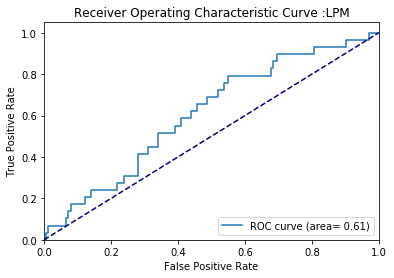

In [28]:
#ROC 커브 그래프에 나타내기

#그래프 그리기 시작
plt.figure()
#x축, y축 지정해주기
plt.plot(fpr, tpr, label='ROC curve (area= %0.2f)' % roc_auc)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :LPM')
plt.legend(loc="lower right")

plt.show()

In [29]:
#최적 threshold 찾기 

#fpr, tpr, threshold 로 구성된 dataframe 생성하기
roc_result = DataFrame([fpr,tpr,thresholds], index=['fpr','tpr','thresholds']).T
# (1-fpr)+(tpr)값을 계산하여 'best'라는 이름의 칼럼 생성하기
roc_result['best'] = (1-roc_result.fpr)+(roc_result.tpr) # specificity + sensitivity
roc_result.head()

,fpr,tpr,thresholds,best
0,0.000000,0.000000,1.319158,1.000000
1,0.005848,0.000000,0.319158,0.994152
2,0.005848,0.034483,0.293593,1.028635
3,0.011696,0.034483,0.277898,1.022787
4,0.011696,0.068966,0.259316,1.057270


### Linear Probability Model의 문제: 예측 확률이 음수가 되거나 1보다 커지는 경우가 발생. 이에 따라 optimal threshold도 1보다 커지는 문제가 발생할 수 있음

In [30]:
#최적 threshold는 best의 값이 최대가 될 때의 threshold 값
optimal_threshold=roc_result.thresholds[roc_result.best.idxmax()] 
#roc_result.best.idxmax()는 best값이 max 일때의 index를 의미
optimal_threshold

0.101230638449355

# Confusion Matrix 구성하기

In [31]:
#각 모형 별로 optimal threshold를 이용하여 binary (0 or 1) 로 예측
result['lpm_binary']=np.where(result.lpm_pred_prob>=optimal_threshold,1,0)

In [32]:
lpm_con = confusion_matrix(y_test, result.lpm_binary)
lpm_con

array([[77, 94],
       [ 6, 23]], dtype=int64)

In [33]:
tn, fp, fn, tp = confusion_matrix(y_test, result.lpm_binary).ravel()
(tn, fp, fn, tp)

(77, 94, 6, 23)

In [34]:
tp/(tp+fn) # tpr = sensitivity

0.7931034482758621

In [35]:
fp/(tn+fp) # fpr = 1-specificity

0.54970760233918126

In [36]:
(tn+tp)/(tn+fp+fn+tp) # accuracy

0.5

# 실습 예제1
## 아래 자료는 어떤 대학원에 지원한 학생들의 입학 허가 여부, GRE 점수, 학점(GPA), 졸업 등수를 나타낸 자료이다.

In [37]:
data1=pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")

### 1) 위의 데이터를 6:4로 나누어 training set과 test set으로 각각 구성하라.
### 2) linear probability model을 이용하여 제반 설명 변수가 대학원 입학 허가 여부 확률에 미치는 영향을 추정하라
####     (hint: constant 옵션을 설정해야 함).
### 3) 추정된 모형으로 out-of-sample test를 하고, test set의 predicted probability의 kernel density function을 그려라.
### 4) test set을 이용하여 ROC 커브를 그리고 AUC를 계산하고, sensitivity와 specificity의 합을 가장 높이는 cut-off point를 구하라.
### 5) 위에서 구한 cut-off point에서 모형의 accuracy를 구하라.

In [38]:
print(data1.shape)
print(data1.head())

(400, 4)
   admit  gre   gpa  rank
0      0  380  3.61     3
1      1  660  3.67     3
2      1  800  4.00     1
3      1  640  3.19     4
4      0  520  2.93     4


In [39]:
df1 = DataFrame(data1)

In [40]:
train1, test1 = np.split(df1.sample(frac=1), [int(.6*len(df1))])

In [41]:
y_train1 = train1['admit']
X_train1 = train1.drop('admit',axis=1)
y_test1 = test1['admit']
X_test1 = test1.drop('admit',axis=1)

In [42]:
print(train1.shape)
print(test1.shape)

(240, 4)
(160, 4)


In [43]:
print(train1.admit.describe())
print(test1.admit.describe())

count    240.000000
mean       0.287500
std        0.453543
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: admit, dtype: float64
count    160.000000
mean       0.362500
std        0.482231
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: admit, dtype: float64


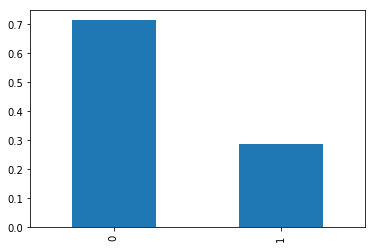

In [44]:
(train1.admit.value_counts()/len(train1)).plot(kind='bar')

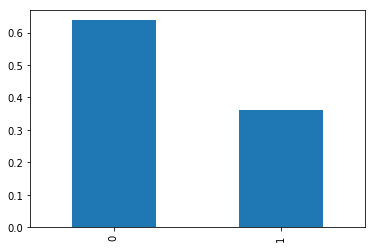

In [45]:
(test1.admit.value_counts()/len(test1)).plot(kind='bar')

In [46]:
lpm = LinearRegression(fit_intercept=True)  
lpm.fit(X_train1,y_train1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
print(lpm.intercept_)
print(lpm.coef_)

-0.427129880519
[ 0.00052851  0.17443642 -0.0758792 ]


In [48]:
train1['pred_prob'] = lpm.predict(X_train1)

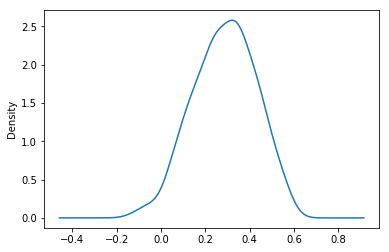

In [49]:
train1.pred_prob.plot(kind='kde')

In [51]:
result1 = lpm.predict(X_test1)
result1 = DataFrame(result1)
result1.columns=['pred_prob']

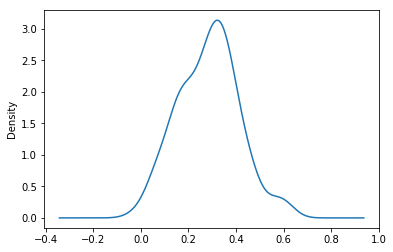

In [52]:
result1.pred_prob.plot(kind='kde')

In [53]:
fpr1,tpr1,thresholds1 = roc_curve(test1.admit, result1.pred_prob)

In [54]:
roc_auc1 = auc(fpr1, tpr1)
roc_auc1

0.68145706558485464

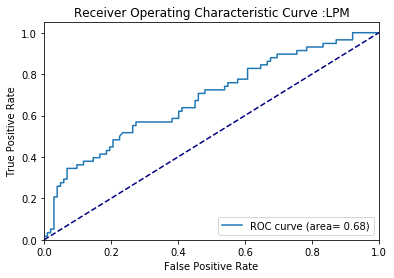

In [55]:
#ROC 커브 그래프에 나타내기

#그래프 그리기 시작
plt.figure()
#x축, y축 지정해주기
plt.plot(fpr1, tpr1, label='ROC curve (area= %0.2f)' % roc_auc1)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :LPM')
plt.legend(loc="lower right")

plt.show()

In [56]:
roc_result1 = DataFrame([fpr1,tpr1,thresholds1], index=['fpr','tpr','thresholds']).T
roc_result1['best'] = (1-roc_result1.fpr)+(roc_result.tpr)
roc_result1.head()

,fpr,tpr,thresholds,best
0,0.000000,0.017241,0.617541,1.000000
1,0.009804,0.017241,0.612308,0.990196
2,0.009804,0.034483,0.596401,1.024679
3,0.019608,0.034483,0.570444,1.014875
4,0.019608,0.051724,0.565211,1.049358


In [57]:
optimal_threshold1 = roc_result1.thresholds[roc_result1.best.idxmax()] 
optimal_threshold1

0.24484988349542558

In [58]:
result1['lpm_binary']=np.where(result1.pred_prob>=optimal_threshold1,1,0)

In [59]:
lpm_con1 = confusion_matrix(test1.admit, result1.lpm_binary)
lpm_con1

array([[43, 59],
       [14, 44]], dtype=int64)

In [60]:
tn, fp, fn, tp = confusion_matrix(y_test, result.lpm_binary).ravel()
accuracy = (tn+tp)/(tn+fp+fn+tp)

In [61]:
print("Linear Probability Model의 accuracy는 %0.2f 이다." %accuracy)

Linear Probability Model의 accuracy는 0.50 이다.


# 로지스틱 회귀분석(Logit model)

In [62]:
#Logistic 회귀분석 모형으로 동일한 training set 분석
logit = LogisticRegression(fit_intercept=False)
logit.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [63]:
#변수별 계수 확인하기
print(logit.intercept_)
print(logit.coef_)

0.0
[[ -3.75429635e-10  -2.79621469e-11  -4.93130825e-11   0.00000000e+00
   -5.26253394e-11  -4.95127608e-10  -1.02025955e-11  -2.83573887e-10
   -1.31755106e-10  -9.00012105e-11  -4.48014381e-10  -5.73158230e-11
   -4.64382963e-06  -1.52763366e-07  -2.79682591e-05  -7.65045758e-09
   -8.72660252e-11  -3.53806017e-10  -4.79926437e-09  -2.41593554e-11
   -1.06240540e-08  -1.59801646e-11  -2.63343071e-09  -2.69815970e-10
   -4.39192776e-09]]


In [64]:
#training set에서 예측 확률 계산하기 
# logit.predict_proba(X_train) 는 0이 될 확률, 1이 될 확률을 모두 반환함. 두번째 칼럼만 이용.
logit.predict_proba(X_train)[:,1]

array([  2.28810981e-01,   8.56498293e-02,   1.59081489e-01,
         2.12456584e-01,   3.24040593e-01,   2.37952588e-01,
         1.42467743e-01,   2.94059890e-01,   2.88754444e-01,
         3.58908511e-02,   1.21041609e-01,   2.44988718e-01,
         1.68878396e-01,   1.51391467e-01,   1.44932373e-01,
         1.66967089e-01,   1.51285379e-01,   9.56856998e-02,
         3.48721212e-01,   2.10804267e-02,   3.38791946e-01,
         1.80309845e-01,   7.39253323e-02,   9.98792295e-03,
         1.86420769e-01,   3.15437064e-01,   8.09230612e-02,
         2.96459581e-01,   3.92963547e-01,   1.53963914e-01,
         2.69257623e-01,   4.28937141e-02,   1.03148962e-01,
         1.33490691e-01,   1.00271677e-01,   1.04770592e-01,
         1.56975473e-01,   7.49794969e-03,   9.82260407e-02,
         8.14871385e-02,   7.90271799e-02,   3.18321024e-02,
         3.14452006e-01,   1.50578895e-01,   4.11092335e-02,
         1.88889619e-01,   7.05695915e-02,   1.91779370e-01,
         1.47119768e-01,

In [65]:
#data set에 칼럼으로 추가.
train['logit_pred_prob'] = logit.predict_proba(X_train)[:,1]

In [66]:
train.head()

,bad,purpose_1,purpose_2,purpose_3,purpose_4,purpose_5,term_1,term_2,verification_status_1,verification_status_2,...,inq_last_6mths,open_acc,pub_rec,total_acc,pub_rec_bankruptcies,emp_length,pop,urate,lpm_pred_prob,logit_pred_prob
701,0,0,0,0,0,1,1,0,0,1,...,0,6,0,8,0,3,3170574,7.700000,0.158426,0.228811
732,0,1,0,0,0,0,0,1,0,0,...,0,6,0,18,0,0,17935472,8.112245,0.194650,0.085650
184,0,1,0,0,0,0,1,0,0,0,...,0,9,0,34,0,8,4581520,10.111111,0.061933,0.159081
579,0,1,0,0,0,0,1,0,0,1,...,0,9,0,19,0,10,18968530,9.643903,0.099664,0.212457
764,0,1,0,0,0,0,1,0,1,0,...,3,17,0,27,0,5,4849463,10.337037,0.184378,0.324041


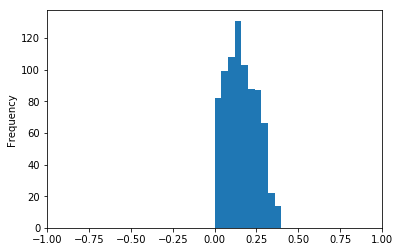

In [67]:
#predicted prob 분포 확인하기
train.logit_pred_prob.plot(kind='hist',bins=10, xlim=([-1,1]))
#train.logit_predict.plot(kind='kde',xlim=([-1,1]))

In [68]:
#logit 결과를 test set에 predict해서 result에 저장 
result['logit_pred_prob'] = logit.predict_proba(X_test)[:,1]

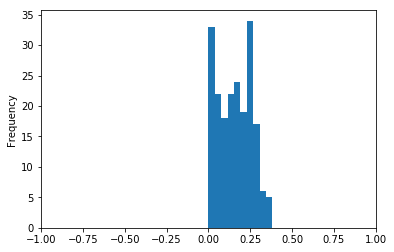

In [69]:
#분포 확인하기 
result.logit_pred_prob.plot(kind='hist',bins=10, xlim=([-1,1]))
#test.logit_predict.plot(kind='kde', xlim=([0,1]))

In [70]:
#lpm과 동일하게 logit에도 auc, roc 구하는 방법 적용
#roc_curve를 이용하여 FPR, TPR, Threshold 설정하기 
fpr_logit,tpr_logit,thresholds_logit = roc_curve(test.bad, result.logit_pred_prob)

In [71]:
#auc 구하기
roc_auc_logit = auc(fpr_logit, tpr_logit)
roc_auc_logit

0.47570074611816904

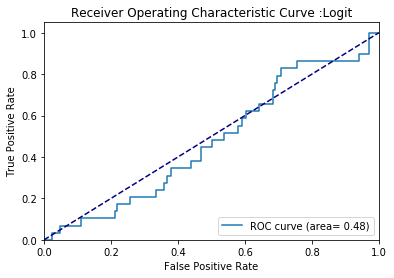

In [72]:
#lpm과 동일한 방법으로 AUROC 그리기

plt.figure()
plt.plot(fpr_logit, tpr_logit, label='ROC curve (area= %0.2f)' % roc_auc_logit)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :Logit')
plt.legend(loc="lower right")

plt.show()

In [73]:
#logit에서 최적 threshold 찾기 (lpm과 방법 동일)
roc_result = DataFrame([fpr_logit,tpr_logit,thresholds_logit], index=['fpr_logit','tpr_logit','thresholds_logit']).T
roc_result['best'] = (1-roc_result['fpr_logit'])+(roc_result['tpr_logit'])
roc_result.head()

,fpr_logit,tpr_logit,thresholds_logit,best
0,0.000000,0.000000,1.382904,1.000000
1,0.005848,0.000000,0.382904,0.994152
2,0.023392,0.000000,0.351604,0.976608
3,0.023392,0.034483,0.346618,1.011091
4,0.046784,0.034483,0.321358,0.987699


In [74]:
optimal_threshold_logit=roc_result.thresholds_logit[roc_result.best.idxmax()]
optimal_threshold_logit

0.078860320222999505

# Confusion Matrix 구성하기

In [75]:
#각 모형 별로 optimal threshold를 이용하여 binary (0 or 1) 로 예측
result['logit_binary']=np.where(result.logit_pred_prob>=optimal_threshold_logit,1,0)

In [76]:
logit_con = confusion_matrix(y_test, result.logit_binary)
logit_con

array([[ 50, 121],
       [  5,  24]], dtype=int64)

In [77]:
tn, fp, fn, tp = confusion_matrix(y_test, result.logit_binary).ravel()
(tn, fp, fn, tp)

(50, 121, 5, 24)

In [78]:
tp/(tp+fn) # tpr = sensitivity

0.82758620689655171

In [79]:
fp/(tn+fp) # fpr = 1-specificity

0.70760233918128657

In [80]:
(tn+tp)/(tn+fp+fn+tp) # accuracy

0.37

# LPM과 Logit 비교하기

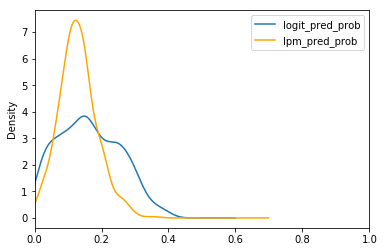

In [81]:
#predicted probability 비교하기 (training set)
plt.figure()
train.logit_pred_prob.plot(kind='kde',xlim=([0,1]), legend=True)
train.lpm_pred_prob.plot(kind='kde', color='orange',xlim=([0,1]), legend=True)
plt.show()

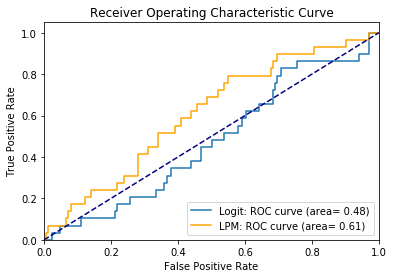

In [82]:
# AUROC 비교하기

plt.figure()
plt.plot(fpr_logit, tpr_logit, label='Logit: ROC curve (area= %0.2f)' % roc_auc_logit)
plt.plot(fpr, tpr, color='orange', label='LPM: ROC curve (area= %0.2f)' % roc_auc)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")

plt.show()


# 실습예제2

In [83]:
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### 변수 설명

###### Survived - Survival (0 = No; 1 = Yes)
###### Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
###### Name - Name
###### Sex - Sex
###### Age - Age
###### SibSp - Number of Siblings/Spouses Aboard
###### Parch - Number of Parents/Children Aboard
###### Ticket - Ticket Number
###### Fare - Passenger Fare (British pound)
###### Cabin - Cabin
###### Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

### 1) 위의 데이터 셋을 이용하여 데이터 클리닝 후 7:3으로 training set과 test set을 구성하라.
### (hint: NaN이 있는 변수 처리, 카테고리 변수를 더미화 하기 등)
### 2) lpm과 logit model을 이용하여 out-of-sample test를 하고,
### 3) 두 모형의 predicted probability를 비교하는 그림을 그려라.
### 4) 두 모형의 AUC를 구하고, ROC를 그려라.
### 5) 두 모형의 confusion matrix를 구하고, accuracy가 어떻게 다른지 보라.
### (이 때 optimal threshold는 sensitivity와 specificity의 합을 가장 높여주는 것으로 한다)

In [84]:
titanic.shape

(891, 12)

In [85]:
# missing values 개수 구하기
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [86]:
# survival probability에 영향이 없거나 missing이 너무 많은 변수 제외하기
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


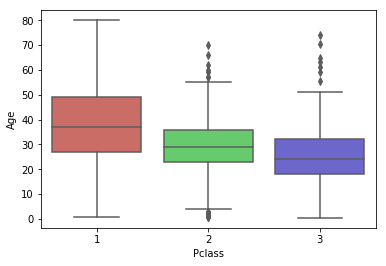

In [87]:
# Age 변수의 missing value 처리하기
# Age 변수와 연관이 있을 것 같은 변수(Pclass)의 box plot을 그림
sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')

In [88]:
titanic_data.groupby('Pclass').Age.mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [89]:
df = titanic_data 

In [90]:
df.Age = np.where((df.Age.isnull()==True)&(df.Pclass==1), df.Age[df.Pclass==1].mean(), df.Age)
df.Age = np.where((df.Age.isnull()==True)&(df.Pclass==2), df.Age[df.Pclass==2].mean(), df.Age)
df.Age = np.where((df.Age.isnull()==True)&(df.Pclass==3), df.Age[df.Pclass==3].mean(), df.Age)

In [91]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [92]:
# Embarked 변수의 missing value 2개는 drop 처리
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [93]:
# Categorical 변수인 Sex, Embarked를 get_dummies를 이용하여 dummy변수화
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)

In [94]:
# Sex, Embarked를 기존 데이터 셋에서 제외하고 gender와 embark_location을 concatenate한 새로운 데이터 셋 구성
titanic_dmy = pd.concat([titanic_data.drop(['Sex', 'Embarked'],axis=1),gender,embark_location],axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [95]:
# 열 이름 변경
titanic_dmy.rename(columns={'male':'gender','Q':'embark_location_Q','S':'embark_location_S'}, inplace=True)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,gender,embark_location_Q,embark_location_S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [96]:
titanic_dmy.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,gender,embark_location_Q,embark_location_S
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,29.246290,0.524184,0.382452,32.096681,0.649044,0.086614,0.724409
std,0.486260,0.834700,13.176451,1.103705,0.806761,49.697504,0.477538,0.281427,0.447063
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000
50%,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200,1.000000,0.000000,1.000000
75%,1.000000,3.000000,36.500000,1.000000,0.000000,31.000000,1.000000,0.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


In [97]:
# 이하는 실습 시간에 진행한 내용과 동일
df = DataFrame(titanic_dmy)
train2, test2 = np.split(df.sample(frac=1), [int(.7*len(df))])
print(train2.shape)
print(test2.shape)

(622, 9)
(267, 9)


In [98]:
# 종속 변수, 설명 변수 설정
y_train2 = train2['Survived']
X_train2 = train2.drop('Survived',axis=1)
y_test2 = test2['Survived']
X_test2 = test2.drop('Survived',axis=1)

In [99]:
# lpm 모형
lpm = LinearRegression(fit_intercept=True) 
lpm.fit(X_train2,y_train2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [100]:
# 로짓 모형
logit = LogisticRegression(fit_intercept=True)
logit.fit(X_train2,y_train2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [102]:
result2 = lpm.predict(X_test2)
result2 = DataFrame(result2)
result2.columns=['lpm_pred_prob']
result2['logit_pred_prob'] = logit.predict_proba(X_test2)[:,1]

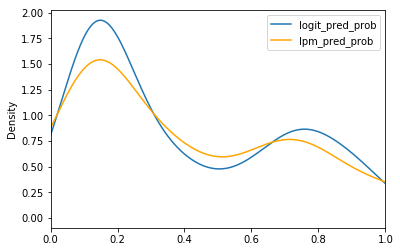

In [103]:
plt.figure()
result2.logit_pred_prob.plot(kind='kde',xlim=([0,1]), legend=True)
result2.lpm_pred_prob.plot(kind='kde', color='orange',xlim=([0,1]), legend=True)
plt.show()

In [104]:
fpr_lpm, tpr_lpm, thresholds_lpm = roc_curve(y_test2, result2.lpm_pred_prob)
fpr_logit,tpr_logit,thresholds_logit = roc_curve(y_test2, result2.logit_pred_prob)

In [105]:
roc_auc_lpm = auc(fpr_lpm, tpr_lpm)
roc_auc_logit = auc(fpr_logit, tpr_logit)

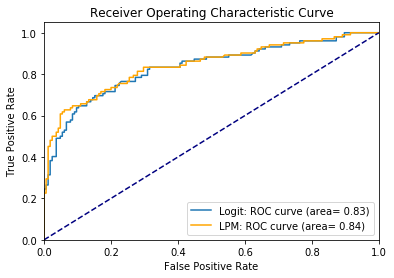

In [106]:
plt.figure()
plt.plot(fpr_logit, tpr_logit, label='Logit: ROC curve (area= %0.2f)' % roc_auc_logit)
plt.plot(fpr_lpm, tpr_lpm, color='orange', label='LPM: ROC curve (area= %0.2f)' % roc_auc_lpm)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")

plt.show()

In [107]:
roc_result2 = DataFrame([fpr_lpm,tpr_lpm,thresholds_lpm], index=['fpr_lpm','tpr_lpm','thresholds_lpm']).T
roc_result2['best_lpm'] = (1-roc_result2.fpr_lpm)+(roc_result2.tpr_lpm)
optimal_threshold_lpm = roc_result2.thresholds_lpm[roc_result2.best_lpm.idxmax()] 
optimal_threshold_lpm

0.66578746901322761

In [108]:
roc_result2 = DataFrame([fpr_logit,tpr_logit,thresholds_logit], index=['fpr_logit','tpr_logit','thresholds_logit']).T
roc_result2['best_logit'] = (1-roc_result2['fpr_logit'])+(roc_result2['tpr_logit'])
optimal_threshold_logit=roc_result2.thresholds_logit[roc_result2.best_logit.idxmax()]
optimal_threshold_logit

0.50168281927589731

In [109]:
#각 모형 별로 optimal threshold를 이용하여 binary (0 or 1) 로 예측
result2['lpm_binary']   = np.where(result2.lpm_pred_prob   >= optimal_threshold_lpm,1,0)
result2['logit_binary'] = np.where(result2.logit_pred_prob >= optimal_threshold_logit,1,0)

In [110]:
tn, fp, fn, tp = confusion_matrix(y_test2, result2.lpm_binary).ravel()
lpm_accuracy = (tn+tp)/(tn+fp+fn+tp)

In [111]:
tn, fp, fn, tp = confusion_matrix(y_test2, result2.logit_binary).ravel()
logit_accuracy = (tn+tp)/(tn+fp+fn+tp)

In [112]:
print("선형확률모형의 accuracy는 %0.2f 이다." % lpm_accuracy)
print("로짓모형의 accuracy는 %0.2f 이다." % logit_accuracy)

선형확률모형의 accuracy는 0.82 이다.
로짓모형의 accuracy는 0.79 이다.
